In [1]:
from tensorflow import keras
from keras.datasets import cifar10
import os
import time
import numpy as np
# Library for plot the output and save to file                                  
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import time

import math
from pycuda import gpuarray
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

%matplotlib inline


In [2]:

baseDir = os.path.dirname(os.path.abspath('__file__')) + '/'
classesName = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
xVal = xTrain[49000:, :].astype(np.float)
yVal = np.squeeze(yTrain[49000:, :])
xTrain = xTrain[:49000, :].astype(np.float)
yTrain = np.squeeze(yTrain[:49000, :])
yTest = np.squeeze(yTest)
xTest = xTest.astype(np.float)


# In[24]:



# In[32]:



# In[33]:


# Pre processing data                                                           
# Normalize the data by subtract the mean image                                 
meanImage = np.mean(xTrain, axis=0)
xTrain -= meanImage
xVal -= meanImage
xTest -= meanImage

# Reshape data from channel to rows                                             
xTrain = np.reshape(xTrain, (xTrain.shape[0], -1))
xVal = np.reshape(xVal, (xVal.shape[0], -1))
xTest = np.reshape(xTest, (xTest.shape[0], -1))
# Add bias dimension columns                                                    
xTrain = np.hstack([xTrain, np.ones((xTrain.shape[0], 1))])
xVal = np.hstack([xVal, np.ones((xVal.shape[0], 1))])
xTest = np.hstack([xTest, np.ones((xTest.shape[0], 1))])


class Svm (object):
    """" Svm classifier """

    def __init__ (self, inputDim, outputDim):
        self.W = None
        sigma =0.01
        self.W = sigma * np.random.randn(inputDim,outputDim)
        self.s_dummy = np.zeros((200,10)).astype(np.float32)
        self.time1=0
        self.time2=0
        self.time3=0
        self.time4=0
        self.time5=0
        self.time6=0
        self.time7=0
        self.time8=0
        self.final_time=0

    def calLoss (self, x, y, reg): # x is a 2D array. num of rows is the num of examples


        ### 1st kerel #############################
        dW = np.zeros_like(self.W).astype(np.float32)

        # tiled-version of dot product of x and w
        # we have too kernels ready, x_dot_w.cu and x_dot_w_tile.cu
        
        prg_sgd1 = SourceModule(open("../kernels/x_dot_w.cu", "r").read())
        func1 = prg_sgd1.get_function("x_dot_w")
        
        batchSize = x.shape[0]
        featureSize = x.shape[1]
        
        dim0 = 10
        dim1 = 100
        block_dim = (dim0, dim1, 1)
        grid_dim = (1, math.ceil(x.shape[0]/dim1), 1)

        d_x = gpuarray.to_gpu(x.astype(np.float32))
        d_w = gpuarray.to_gpu(self.W.astype(np.float32))
        d_s = gpuarray.empty(self.s_dummy.shape ,dtype=np.float32)
        a_start = cuda.Event()
        a_end = cuda.Event()
        a_start.record()
        func1( d_x , d_w , d_s,
                np.int32(batchSize),
                np.int32(featureSize),
                np.int32(10),
                block=block_dim,
                grid=grid_dim)
        
        a_end.record()
        a_end.synchronize()
        # time1 is the execution of the 1st kernel.
        self.time1= a_start.time_till(a_end) *(1e-3)
        s = d_s.get()
        a_s = time.time()
        s_yi = s[np.arange(x.shape[0]),y]
        ae = time.time()
        # time2 is to calculate s_yi
        self.time2= ae- a_s



        #####  2nd kernel ############################
        ## not using max_epoch ###
        dim02 = 10
        dim12 = 10
        
        block_dim = (dim02, dim12, 1)
        prg_sgd2 = SourceModule(open("../kernels/delta.cu", "r").read())
        func2 = prg_sgd2.get_function("delta")
        
        d_s =  gpuarray.to_gpu(s.astype(np.float32))
        d_y =  gpuarray.to_gpu(s_yi.astype(np.float32))
        d_delta = gpuarray.empty(s.shape ,dtype=np.float32)
        
        b_start = cuda.Event()
        b_end =cuda.Event()
        b_start.record()
        func2( d_s , d_y , d_delta,
                np.int32(batchSize),
                np.int32(10),
                block=block_dim,
               grid=grid_dim)
        b_end.record()
        b_end.synchronize()
        # time3 is the execution time of 2nd kernel
        self.time3= b_start.time_till(b_end)*(1e-3)

        delta = d_delta.get()
        ds = np.zeros_like(delta)
        
        ####   3rd kernel  #############################
        # not using max_epochs #
        block_dim = (10, 10 ,1)
        
        prg_sgd3 = SourceModule(open("../kernels/ds.cu", "r").read())
        func3 = prg_sgd3.get_function("ds")

        d_ds =  gpuarray.to_gpu(ds.astype(np.float32))
        d_y =  gpuarray.to_gpu(y.astype(np.int32))
        d_delta = gpuarray.to_gpu(delta.astype(np.float32))

        c_start =cuda.Event()
        c_end = cuda.Event()
        c_start.record()
        func3( d_ds , d_y , d_delta,
                   np.int32(batchSize),
                   np.int32(10),
                   block=block_dim,
                   grid=grid_dim)
        c_end.record()
        c_end.synchronize()
        # time5 is the execution time of the 3rd kernel
        self.time5= c_start.time_till(c_end)*(1e-3)        
        ds = d_ds.get()

        c_s =time.time()
        ds[np.arange(x.shape[0]),y] = -np.sum(ds, axis=1)
        c_e = time.time()
        # time6 is to calculate ds[] 
        self.time6= c_e - c_s


        ### 4th kernel  ####################
        # not using max_epoch
        prg_sgd6 = SourceModule(open("../kernels/xT.cu", "r").read())

        dim00 = 32
        dim11= 32

        block_dim2 = (dim00, dim11, 1)
        grid_dim2 = (math.ceil(x.shape[0]/dim00), math.ceil(x.shape[1]/dim11) , 1)

        func6 = prg_sgd6.get_function("xT")
        d_xp  = gpuarray.to_gpu(x.astype(np.float32))
        d_XT  = gpuarray.empty((3073,200), dtype=np.float32 )
        d_start =cuda.Event()
        d_end= cuda.Event()
        d_start.record()
        func6( d_xp, d_XT, 
               np.int32(batchSize),
               np.int32(featureSize),
               block=block_dim2,  grid=grid_dim2)
        d_end.record()
        d_end.synchronize()
        # time4 is for the execution time for the 4th kernel
        self.time4= d_start.time_till(d_end)*(1e-3)


        #####   5th kernel #################################
        ## have 2 versions of kernel, get_w_combo.cu and get_w_combo_tiled.cu 
        prg_sgd5 = SourceModule(open("../kernels/get_w_combo.cu", "r").read())
        dim00 =10
        dim11= 100
        block_dim2 = (dim00, dim11, 1)
        grid_dim2 = (math.ceil(dW.shape[1]/dim00), math.ceil(dW.shape[0]/dim11) , 1)
        
        func5 = prg_sgd5.get_function("get_w_combo")
        
        d_xp  = gpuarray.to_gpu(d_XT.get().astype(np.float32))
        d_DS  = gpuarray.to_gpu(ds.astype(np.float32))
        d_W = gpuarray.to_gpu(self.W.astype(np.float32))
        
        d_start =cuda.Event()
        d_end= cuda.Event()
        d_start.record()
        
        func5( d_xp, d_DS, d_W,
               np.int32(featureSize),
               np.int32(batchSize),
               np.int32(10),
               block=block_dim2,  grid=grid_dim2)
        
        d_end.record()
        d_end.synchronize()
        ## time7 is for the 5th kernel.
        self.time7= d_start.time_till(d_end)*(1e-3)
        

        # total time for execution.
        self.final_time+= self.time1 + self.time2 + self.time3 + self.time4 +self.time5 +self.time6 +self.time7 
        self.W = d_W.get()
        return self.W 
  
    def train (self, x, y, lr=1e-3, reg=1e-5, iter=100, batchSize=200, verbose=False):
        # Run stochastic gradient descent to optimize W. 
        lossHistory = []
        for i in range(iter):
            xBatch = None
            yBatch = None
            # draw num_train samples from x, num_train is a 1-D array contains integeres
            num_train = np.random.choice(x.shape[0], batchSize)
            xBatch = x[num_train] # xBatch is a 2D array, each row is a data point,
            yBatch = y[num_train]
            w_g  = self.calLoss(xBatch,yBatch,reg)

        print(" EXE time" , self.final_time)
        return self.final_time
    
    
    def predict (self, x,):
        yPred = np.zeros(x.shape[0])
        s = x.dot(self.W)
        yPred = np.argmax(s, axis=1)
        return yPred
    
    def calAccuracy (self, x, y):
        acc = 0
        yPred = self.predict(x)
        acc = np.mean(y == yPred)*100
        return acc
numClasses = np.max(yTrain) + 1


classifier_0 is used to run once for max_epoch = 500

In [ ]:

classifier_0 = Svm(xTrain.shape[1], numClasses)
# Training classifier
startTime = time.time()

classifier_0.train(xTrain, yTrain, lr=1e-7, reg=5e4, iter=500 ,verbose=True)

print ('Training time: {0}'.format(time.time() - startTime))
print ('Training acc:   {0}%'.format(classifier.calAccuracy(xTrain, yTrain)))
print ('Validating acc: {0}%'.format(classifier.calAccuracy(xVal, yVal)))
print ('Testing acc:    {0}%'.format(classifier.calAccuracy(xTest, yTest)))

In [ ]:
we declare a new classifer for each different max_epoch
THe following code section is used to collect time result for different max_epochs

In [42]:
# Training classifier


t = []
acc_tr = []
acc_te = []
#loss_a = []

itr = 50
for i in range(itr):
    max_iter = (i+1) * 10
    classifier = Svm(xTrain.shape[1], numClasses)
    final_time = classifier.train(xTrain, yTrain,
                          lr=1e-7,
                          reg=5e4,
                          iter=max_iter,
                          verbose=True)
    #endTime = time.time()
    
    t.append(final_time)
    acc_tr.append(classifier.calAccuracy(xTrain, yTrain))
    acc_te.append(classifier.calAccuracy(xTest, yTest))



 EXE time 0.006680217444896697
 EXE time 0.0140205893330276
 EXE time 0.02008042417094111
 EXE time 0.026505975406616925
 EXE time 0.03187515468150377
 EXE time 0.03726765068992974
 EXE time 0.045415493935346614
 EXE time 0.049584282848983995
 EXE time 0.058520941440016024
 EXE time 0.06428606432303789
 EXE time 0.06792455107718703
 EXE time 0.07447499871253967
 EXE time 0.07948280949890617
 EXE time 0.08634622369706628
 EXE time 0.09072329537570478
 EXE time 0.09636196387186648
 EXE time 0.10437818259373308
 EXE time 0.11229299353063107
 EXE time 0.12065679584443566
 EXE time 0.12493436143174767
 EXE time 0.12528349928930396
 EXE time 0.13831343713402752
 EXE time 0.14132569206506018
 EXE time 0.14611757806316017
 EXE time 0.15012874438613658
 EXE time 0.1576514026448131
 EXE time 0.16667586933448894
 EXE time 0.17034022808447485
 EXE time 0.18368181658163674
 EXE time 0.1815998864695429
 EXE time 0.1878018690459431
 EXE time 0.19904230426251887
 EXE time 0.2002161139585078
 EXE time 

In [43]:
t

[0.006680217444896697,
 0.0140205893330276,
 0.02008042417094111,
 0.026505975406616925,
 0.03187515468150377,
 0.03726765068992974,
 0.045415493935346614,
 0.049584282848983995,
 0.058520941440016024,
 0.06428606432303789,
 0.06792455107718703,
 0.07447499871253967,
 0.07948280949890617,
 0.08634622369706628,
 0.09072329537570478,
 0.09636196387186648,
 0.10437818259373308,
 0.11229299353063107,
 0.12065679584443566,
 0.12493436143174767,
 0.12528349928930396,
 0.13831343713402752,
 0.14132569206506018,
 0.14611757806316017,
 0.15012874438613658,
 0.1576514026448131,
 0.16667586933448894,
 0.17034022808447485,
 0.18368181658163674,
 0.1815998864695429,
 0.1878018690459431,
 0.19904230426251887,
 0.2002161139585078,
 0.20482395726814864,
 0.2111975748278201,
 0.21821116777881983,
 0.22124964786320916,
 0.23112751746177684,
 0.23511290656775227,
 0.24155329442396767,
 0.24568717763200393,
 0.25316881193593144,
 0.2638752560541032,
 0.2645817940719424,
 0.27484797635674496,
 0.2741554960

In [45]:
acc_tr

[9.189795918367347,
 10.008163265306122,
 10.214285714285715,
 9.79795918367347,
 9.279591836734694,
 11.844897959183672,
 10.540816326530612,
 13.761224489795918,
 14.50612244897959,
 14.034693877551021,
 13.204081632653061,
 14.59795918367347,
 14.057142857142857,
 13.648979591836735,
 16.5,
 17.206122448979592,
 15.202040816326532,
 18.832653061224487,
 16.228571428571428,
 18.208163265306123,
 18.748979591836733,
 18.818367346938775,
 19.634693877551022,
 19.487755102040815,
 21.677551020408163,
 21.151020408163266,
 22.144897959183673,
 22.82857142857143,
 23.79795918367347,
 25.240816326530613,
 24.955102040816328,
 25.740816326530613,
 26.193877551020407,
 28.1,
 28.016326530612247,
 28.828571428571433,
 29.271428571428572,
 30.130612244897957,
 30.695918367346938,
 31.22448979591837,
 32.41836734693877,
 32.8469387755102,
 32.8795918367347,
 33.45102040816327,
 33.64285714285714,
 34.4,
 34.75918367346939,
 34.36530612244898,
 35.26530612244898,
 34.63469387755102]

In [46]:
acc_te

[9.04,
 9.83,
 10.38,
 9.879999999999999,
 9.32,
 11.65,
 10.12,
 13.79,
 14.91,
 13.600000000000001,
 13.52,
 14.85,
 13.639999999999999,
 13.700000000000001,
 16.919999999999998,
 17.4,
 16.09,
 18.66,
 16.7,
 18.26,
 19.31,
 19.09,
 19.73,
 20.46,
 21.740000000000002,
 21.22,
 21.87,
 22.759999999999998,
 22.93,
 24.97,
 24.43,
 25.900000000000002,
 26.240000000000002,
 27.810000000000002,
 28.389999999999997,
 28.21,
 28.74,
 29.86,
 30.18,
 30.3,
 32.26,
 32.879999999999995,
 32.76,
 32.879999999999995,
 33.019999999999996,
 33.7,
 34.99,
 34.260000000000005,
 34.839999999999996,
 34.53]

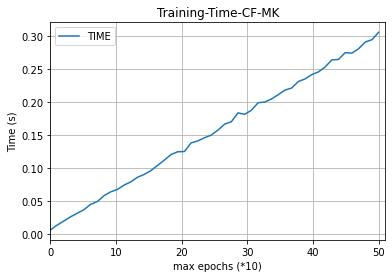

In [47]:
### print time with max_epochs ####
x0 = np.linspace(0, itr, itr)
fig0, ax0 = plt.subplots()
line1, = ax0.plot(x0, t, label='TIME')
ax0.set_title('Training-Time-CF-MK')
ax0.set_xlabel('max epochs (*10)')
ax0.set_ylabel('Time (s)')
#ax0.set_yscale('log')
ax0.grid(True)
ax0.set_xlim(0, itr + 1)
ax0.xaxis.set_ticks(np.arange(0,itr + 1, 10))
ax0.legend()
plt.savefig("../result-plots/CF-MK-Time.png")

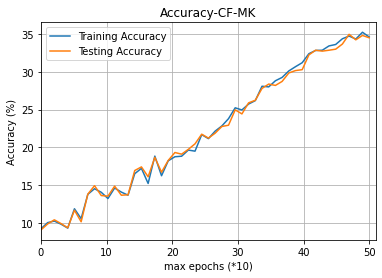

In [48]:
### print accuracy on test and train with max_epochs ###

x1 = np.linspace(0, itr, itr)
fig1, ax1 = plt.subplots()
line1, = ax1.plot(x1, acc_tr, label='Training Accuracy')
line1, = ax1.plot(x1, acc_te, label='Testing Accuracy')
ax1.set_title('Accuracy-CF-MK')
ax1.set_xlabel('max epochs (*10)')
ax1.set_ylabel('Accuracy (%)')

ax1.grid(True)
ax1.set_xlim(0, itr + 1)
ax1.xaxis.set_ticks(np.arange(0,itr + 1, 10))
ax1.legend()
plt.savefig("../result-plots/CF-MK-Accuracy.png")